In [1]:
import requests
from bs4 import BeautifulSoup
import geocoder # import geocoder

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Get the neighborhoods data from LA Times
#### Get the coordinates of these neighborhoods

In [2]:
neighborhoods_file = open("CentralLA_Neighborhoods.json")
neighborhoods = json.load(neighborhoods_file)

content = list()

for neighborhood in neighborhoods['features']:
    
    neighborhood_info = {}
    
    # get the neighborhood name
    name = neighborhood['properties']['name']
    
    # get the coordinates of this neighborhood
    address = '{}, Los Angeles, CA'.format(name)
    geolocator = Nominatim(user_agent="la_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(name, latitude, longitude))
    
    neighborhood_info['Name'] = name
    neighborhood_info['Latitude'] = latitude
    neighborhood_info['Longitude'] = longitude
    
    content.append(neighborhood_info)

# make sure there are 26 neighborhoods
print('There are {} neighborhoods in the list'.format(len(content)))

The geograpical coordinate of Arlington Heights are 34.0434937, -118.3213735.
The geograpical coordinate of Beverly Grove are 34.0760338, -118.3699723.
The geograpical coordinate of Carthay are 34.0611213, -118.3672997.
The geograpical coordinate of Chinatown are 34.0638402, -118.2358676.
The geograpical coordinate of Downtown are 34.0428494, -118.2476732.
The geograpical coordinate of East Hollywood are 34.0904277, -118.2966254.
The geograpical coordinate of Echo Park are 34.074, -118.2608735.
The geograpical coordinate of Elysian Park are 34.0774343, -118.2386204.
The geograpical coordinate of Elysian Valley are 34.0959128, -118.2420326.
The geograpical coordinate of Fairfax are 34.0791555, -118.3522844.
The geograpical coordinate of Griffith Park are 34.1358143, -118.2947892.
The geograpical coordinate of Hancock Park are 34.0677801, -118.332635.
The geograpical coordinate of Harvard Heights are 34.0471105, -118.3054828.
The geograpical coordinate of Hollywood are 34.0980031, -118.3

#### create a dataframe holds all of the data

In [3]:
neighborhood_df = pd.DataFrame(content)
neighborhood_df

,Name,Latitude,Longitude
0,Arlington Heights,34.043494,-118.321374
1,Beverly Grove,34.076034,-118.369972
2,Carthay,34.061121,-118.367300
3,Chinatown,34.063840,-118.235868
4,Downtown,34.042849,-118.247673
5,East Hollywood,34.090428,-118.296625
6,Echo Park,34.074000,-118.260874
7,Elysian Park,34.077434,-118.238620
8,Elysian Valley,34.095913,-118.242033
9,Fairfax,34.079155,-118.352284


#### Create a map of Central LA with neighborhoods superimposed on top.

In [4]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of LA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of LA are 34.0536909, -118.242766.


In [5]:
# create map of Toronto using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(neighborhood_df['Latitude'], neighborhood_df['Longitude'], neighborhood_df['Name']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

#### Define Foursquare Credentials and Version

In [6]:
CLIENT_ID = 'CVF5AHLRBAPXOQHXAYVKI5NOUTMCB4Z100POAFKJMPRCA1DZ' # your Foursquare ID
CLIENT_SECRET = '0RYVSFFRB0ZXJGLGL4TSSC0XVTZTHLJFJKBVHC0NCVO03UQQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Working with neightborhood {}'.format(name))
            
        # create the API request URL
        # categoryId=4d4b7105d754a06374d81259 is restaurant
        
        url = '''
                https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259
                &client_id={}&client_secret={}&v={}&ll={},{}&limit={}
              '''.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
la_venues = getNearbyVenues(names=neighborhood_df['Name'],
                            latitudes=neighborhood_df['Latitude'],
                            longitudes=neighborhood_df['Longitude'])

Working with neightborhood Arlington Heights
Working with neightborhood Beverly Grove
Working with neightborhood Carthay
Working with neightborhood Chinatown
Working with neightborhood Downtown
Working with neightborhood East Hollywood
Working with neightborhood Echo Park
Working with neightborhood Elysian Park
Working with neightborhood Elysian Valley
Working with neightborhood Fairfax
Working with neightborhood Griffith Park
Working with neightborhood Hancock Park
Working with neightborhood Harvard Heights
Working with neightborhood Hollywood
Working with neightborhood Hollywood Hills
Working with neightborhood Hollywood Hills West
Working with neightborhood Koreatown
Working with neightborhood Larchmont
Working with neightborhood Los Feliz
Working with neightborhood Mid-City
Working with neightborhood Mid-Wilshire
Working with neightborhood Pico-Union
Working with neightborhood Silver Lake
Working with neightborhood West Hollywood
Working with neightborhood Westlake
Working with nei

In [9]:
print('There are total of {} results'.format(len(la_venues)))
la_venues.head()

There are total of 2531 results


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arlington Heights,34.043494,-118.321374,Pasta Sisters,34.047503,-118.317216,Italian Restaurant
1,Arlington Heights,34.043494,-118.321374,Cafe Dabang,34.047407,-118.319082,Café
2,Arlington Heights,34.043494,-118.321374,Gus's World Famous Fried Chicken,34.047946,-118.326472,Fried Chicken Joint
3,Arlington Heights,34.043494,-118.321374,The Grain Cafe,34.047713,-118.327601,Vegetarian / Vegan Restaurant
4,Arlington Heights,34.043494,-118.321374,La Cevicheria,34.047654,-118.322810,Latin American Restaurant


In [10]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# Since there are categories with name 'Neighborhood' toronto_venues dataframe, we should use another name
la_onehot.insert(0, 'Neighborhood Name', la_venues['Neighborhood'])

la_onehot.head()

,Neighborhood Name,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Arlington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arlington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arlington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arlington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Arlington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
print('Shape of onehot encoded dataframe is {}'.format(la_onehot.shape))
print('There are {} restaurants and {} types of cuisine'.format(la_onehot.shape[1], la_onehot.shape[0]))

Shape of onehot encoded dataframe is (2531, 97)
There are 97 restaurants and 2531 types of cuisine


#### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [12]:
la_grouped = la_onehot.groupby('Neighborhood Name').mean().reset_index()
la_grouped

,Neighborhood Name,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Arlington Heights,0.00,0.00,0.000000,0.00,0.000000,0.020000,0.000000,0.020000,0.00,0.010000,0.00,0.040000,0.00,0.00,0.000000,0.030000,0.00,0.000000,0.01,0.040000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.020000,0.01,0.00,0.00,0.01,0.00,0.050000,0.01,0.00,0.000000,0.010000,0.00,0.010000,0.000000,0.010000,0.000000,0.000000,0.01,0.000000,0.010000,0.000000,0.00,0.00,0.010000,0.030000,0.000000,0.00,0.32,0.01,0.02,0.00,0.00,0.000000,0.070000,0.000000,0.000000,0.010000,0.010000,0.00,0.00,0.00,0.00,0.040000,0.000000,0.000000,0.010000,0.000000,0.000000,0.050000,0.00,0.000000,0.00,0.000000,0.000000,0.01,0.01,0.00,0.000000,0.010000,0.00,0.030000,0.00,0.00,0.000000,0.00,0.010000,0.010000,0.02
1,Beverly Grove,0.00,0.00,0.050000,0.00,0.010000,0.020000,0.010000,0.030000,0.01,0.020000,0.00,0.000000,0.00,0.00,0.000000,0.100000,0.00,0.000000,0.00,0.020000,0.01,0.00,0.000000,0.000000,0.010000,0.01,0.030000,0.01,0.020000,0.01,0.01,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.040000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.030000,0.00,0.00,0.040000,0.030000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.030000,0.070000,0.000000,0.000000,0.010000,0.010000,0.00,0.01,0.01,0.00,0.040000,0.020000,0.000000,0.020000,0.000000,0.010000,0.020000,0.01,0.030000,0.00,0.000000,0.000000,0.00,0.01,0.01,0.030000,0.060000,0.01,0.000000,0.00,0.00,0.010000,0.00,0.060000,0.000000,0.00
2,Carthay,0.01,0.00,0.030000,0.00,0.030000,0.010000,0.000000,0.030000,0.00,0.030000,0.00,0.040000,0.00,0.00,0.000000,0.060000,0.00,0.000000,0.00,0.010000,0.01,0.00,0.000000,0.010000,0.000000,0.00,0.010000,0.00,0.010000,0.00,0.00,0.00,0.07,0.00,0.040000,0.00,0.01,0.010000,0.000000,0.00,0.050000,0.030000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.030000,0.00,0.01,0.040000,0.020000,0.000000,0.00,0.01,0.01,0.00,0.00,0.00,0.010000,0.040000,0.000000,0.000000,0.020000,0.000000,0.00,0.01,0.00,0.00,0.040000,0.030000,0.000000,0.020000,0.000000,0.010000,0.050000,0.00,0.010000,0.00,0.010000,0.000000,0.00,0.00,0.01,0.020000,0.070000,0.01,0.000000,0.00,0.00,0.010000,0.00,0.000000,0.010000,0.00
3,Chinatown,0.00,0.00,0.030000,0.00,0.020000,0.010000,0.000000,0.060000,0.00,0.000000,0.00,0.010000,0.00,0.00,0.000000,0.030000,0.01,0.000000,0.00,0.230000,0.00,0.00,0.000000,0.000000,0.020000,0.03,0.010000,0.00,0.000000,0.00,0.00,0.00,

#### create the new dataframe and display the top 10 venues for each neighborhood.

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [14]:
num_top_venues = 5

columns = ['Neighborhood Name'] + ['No.{} Popular Cuisine'.format(str(i+1)) for i in range(num_top_venues)]

# create a new dataframe
la_restaurants_sorted = pd.DataFrame(columns=columns)
la_restaurants_sorted['Neighborhood Name'] = la_grouped['Neighborhood Name']

# find the top 5 most popular cuisine in each neighborhood and append it to the df
for idx in np.arange(len(la_grouped)):
    la_restaurants_sorted.iloc[idx, 1:] = return_most_common_venues(la_grouped.iloc[idx], num_top_venues)

la_restaurants_sorted

,Neighborhood Name,No.1 Popular Cuisine,No.2 Popular Cuisine,No.3 Popular Cuisine,No.4 Popular Cuisine,No.5 Popular Cuisine
0,Arlington Heights,Korean Restaurant,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Chinese Restaurant
1,Beverly Grove,Café,Mexican Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
2,Carthay,Sushi Restaurant,Ethiopian Restaurant,Café,Food Truck,Sandwich Place
3,Chinatown,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Bakery,Sandwich Place
4,Downtown,Mexican Restaurant,Sushi Restaurant,Taco Place,Pizza Place,Gastropub
5,East Hollywood,Thai Restaurant,Asian Restaurant,Middle Eastern Restaurant,Pizza Place,Café
6,Echo Park,Mexican Restaurant,Café,Taco Place,Thai Restaurant,Pizza Place
7,Elysian Park,Mexican Restaurant,Taco Place,Bakery,Chinese Restaurant,Pizza Place
8,Elysian Valley,Mexican Restaurant,Café,Pizza Place,Food Truck,American Restaurant
9,Fairfax,Mexican Restaurant,Café,Italian Restaurant,Pizza Place,American Restaurant


In [15]:
# create map of la using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for different cuisines
most_popular_list = list(la_restaurants_sorted['No.1 Popular Cuisine'])
x = np.arange(len(set(most_popular_list)))
ys = [i + x + (i*x)**2 for i in range(len(set(most_popular_list)))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

most_popular_unique_list = list(set(la_restaurants_sorted['No.1 Popular Cuisine']))
# add markers to map
for lat, lng, neighborhood, popular in zip(neighborhood_df['Latitude'], neighborhood_df['Longitude'], neighborhood_df['Name'], la_restaurants_sorted['No.1 Popular Cuisine']):
    label = folium.Popup(neighborhood+', '+popular, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[most_popular_unique_list.index(popular)],
        fill=True,
        fill_color=rainbow[most_popular_unique_list.index(popular)],
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

#### Plot the bar plot to show the result

##### We can see from the result that Mexican cuisine is the most popular cuisine in central LA area.

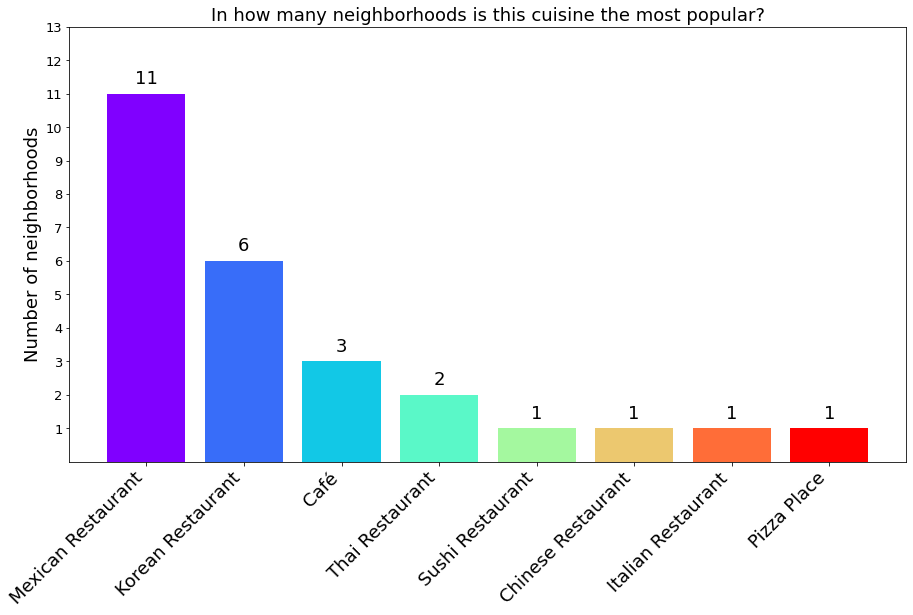

In [68]:
most_popular_dict = dict()

for i in range(len(la_restaurants_sorted)):
    cuisine = la_restaurants_sorted.iloc[i, 1]
    if cuisine in most_popular_dict:
        most_popular_dict[cuisine]+=1
    else:
        most_popular_dict[cuisine]=1

most_popular_pair = sorted(most_popular_dict.items(), key=lambda pair:-pair[1])
most_popular_name = [pair[0] for pair in most_popular_pair]
most_popular_value = [pair[1] for pair in most_popular_pair]

plt.figure(figsize=(15, 8))
plt.bar(most_popular_name, most_popular_value, color=rainbow)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(range(1, most_popular_value[0]+3), fontsize=13)
plt.title('In how many neighborhoods is this cuisine the most popular?', fontsize=18)
plt.ylabel('Number of neighborhoods', fontsize=18)
for name, value in zip(most_popular_name, most_popular_value):
    plt.text(name, value+0.3, str(value), ha = 'center', fontsize=18)
plt.show()

#### Use kmeans to cluster the 26 neighborhoods into groups in terms of types of popular cuisine

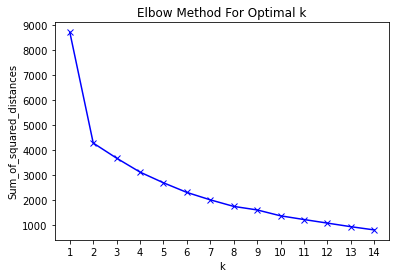

In [79]:
clustering_df = la_grouped.drop('Neighborhood Name', axis=1)

sum_of_squared_distances = []
kclusters = range(1,15)

for k in kclusters:
    clutering_result = KMeans(n_clusters=k, random_state=0).fit(clustering_df)
    sum_of_squared_distances.append(clutering_result.inertia_)

plt.plot(kclusters, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xticks(kclusters)
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [80]:
# set number of clusters
kclusters = 5

# run k-means clustering
clutering_result = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_df)

# check cluster labels generated for each row in the dataframe
clutering_result.labels_

array([3, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 0, 4, 1, 1, 3,
       1, 1, 1, 0])

In [86]:
neighborhood_cluster = pd.DataFrame(neighborhood_df)
neighborhood_cluster['Cluster Label'] = clutering_result.labels_
neighborhood_cluster['Most Popular Cuisine'] = la_restaurants_sorted['No.1 Popular Cuisine']
neighborhood_cluster

,Name,Latitude,Longitude,Cluster Label,Most Popular Cuisine
0,Arlington Heights,34.043494,-118.321374,3,Korean Restaurant
1,Beverly Grove,34.076034,-118.369972,1,Café
2,Carthay,34.061121,-118.367300,1,Sushi Restaurant
3,Chinatown,34.063840,-118.235868,2,Chinese Restaurant
4,Downtown,34.042849,-118.247673,1,Mexican Restaurant
5,East Hollywood,34.090428,-118.296625,4,Thai Restaurant
6,Echo Park,34.074000,-118.260874,1,Mexican Restaurant
7,Elysian Park,34.077434,-118.238620,1,Mexican Restaurant
8,Elysian Valley,34.095913,-118.242033,1,Mexican Restaurant
9,Fairfax,34.079155,-118.352284,1,Mexican Restaurant


#### Create the interactive map showing the most similar neighborhoods in terms of cuisine types. Same group of neighborhoods will be shown in same color.

In [87]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, name, cluster, cuisine in zip(neighborhood_cluster['Latitude'], neighborhood_cluster['Longitude'], neighborhood_cluster['Name'], neighborhood_cluster['Cluster Label'], neighborhood_cluster['Most Popular Cuisine']):
    label = folium.Popup(str(name)+', '+str(cuisine), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters